# USNM 2P data analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset (1 mouse, 1 region).

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import pprint
import numpy as np
import pandas as pd
from IPython.utils import io
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack, view_interactive_plot
from filters import KalmanDenoiser, NoFilter
from interpolators import StackInterpolator, NoInterpolator
from s2putils import *
from postpro import *
from plotters import *
from utils import *

## General parameters

 28/12/2021 20:25:02: input data directory:
/Users/tlemaire/Documents/data/yiyuan/raw/new_experiments_201911/11122019/mouse12/region1
 28/12/2021 20:25:02: figures directory:
/Users/tlemaire/Documents/data/yiyuan/figs


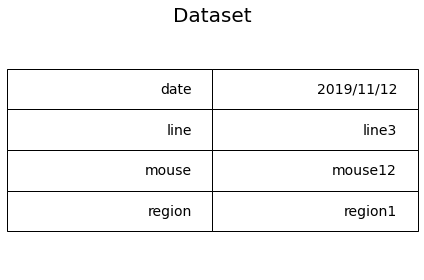

In [3]:
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()

# Logger level
logger.setLevel(logging.INFO)

# Input data directory
dataroot = get_data_root() # Root directory for raw data
date = '11122019'
mouse = 'mouse12'
region = 'region1'
line = 'line3'
datadir = os.path.join(dataroot, date, mouse, region)
logger.info(f'input data directory:\n{datadir}')

# Figures dictionary
figsdir = os.path.join(split_path_at(dataroot, 'raw')[0], 'figs')
if not os.path.isdir(figsdir):
    os.makedirs(figsdir)
logger.info(f'figures directory:\n{figsdir}')
figs = {}

# Inspection of intermediate data
irun_inspect = None  # run index
irun_eq = None
stacktitle = f'run {irun_inspect}'  # stack title
stackdict = None
runbounds = None
istimframes_stacked = None
nROIs_inspect = 3  # number of ROIs

# Create table figure summarizing dataset info
figs['dataset_info'] = plot_table({
    'date': f'{date[4:]}/{date[:2]}/{date[2:4]}',
    'line': line,
    'mouse': mouse,
    'region': region
    })

## Pre-processing (stacking, substitution, denoising)

### Gather data folders

In [4]:
# Get raw list of subolders containing tifs
tif_folders = get_data_folders(datadir, exclude_patterns=['MIP', 'References'], include_patterns=[line])
logger.info(f'Identified folders containing TIF files:\n{pprint.pformat([os.path.basename(x) for x in tif_folders])}')

# Extract acquisition settings from each run
logger.info('extracting aquisition settings...')
daq_settings = parse_aquisition_settings(tif_folders)
daq_settings

 28/12/2021 20:25:03: Identified folders containing TIF files:
['line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860',
 'line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862',
 'line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-865',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-861',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-858',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-863',
 'line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-867',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-857',
 'line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-868',
 'line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-864',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-859',
 'line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-866']
 28/12/2021 20:25:03: extracting aquisition settings...


{'activeMode': 'Galvo',
 'bitDepth': 12.0,
 'currentScanAmplitude': {'XAxis': 7.6, 'YAxis': -7.6},
 'currentScanCenter': {'XAxis': 0.0, 'YAxis': 0.0},
 'daq': ('10x', 'Gain10'),
 'dwellTime': 2.8,
 'framePeriod': 0.280453201144955,
 'interlacedScanTrackCount': 0.0,
 'laserPower': (311.0, 'Pockels'),
 'laserWavelength': (920.0, 'Insight'),
 'linesPerFrame': 256.0,
 'maxVoltage': {'XAxis': 3.19540637796412, 'YAxis': -3.19540637796412},
 'micronsPerPixel': 1.96865654688785,
 'minVoltage': {'XAxis': -3.19540637796412, 'YAxis': 3.19540637796412},
 'objectiveLens': 'Olympus 10X',
 'objectiveLensMag': 10.0,
 'objectiveLensNA': 1.0,
 'opticalZoom': 2.37841423000544,
 'pixelsPerLine': 256.0,
 'pmtGain': {'PMT 1 HV': 0.0, 'PMT 2 HV': 394.7021276596, 'PMT 3 HV': 0.0},
 'positionCurrent': {'XAxis': 1.11, 'YAxis': 2.06, 'ZAxis': 0.05},
 'preampFilter': ('Filter1250KHz', '1.25 MHz'),
 'preampGain': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'preampOffset': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'rasters

### Merge TIFs into stack

In [5]:
# Generate stacks for all TIF folders in the input data directory
raw_stack_fpaths = []
nframes_per_run = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpath, stack_shape = stack_tifs(tif_folder, overwrite=False, full_output=True)
        raw_stack_fpaths.append(stack_fpath)
        nframes_per_run.append(stack_shape[0])

# Extract number of runs
nruns = len(raw_stack_fpaths)
logger.info(f'number of runs: {nruns}')

# Extract and check consistency of number of frames per run
nframes_per_run = list(set(nframes_per_run))
assert len(nframes_per_run) == 1, f'Differing stack lengths: {nframes_per_run}'
nframes_per_run = nframes_per_run[0]
logger.info(f'number of frames per run: {nframes_per_run}')

# Deduce number of trials per run
logger.info(f'number of frames per trial: {NFRAMES_PER_TRIAL}')
ntrials_per_run = nframes_per_run // NFRAMES_PER_TRIAL
logger.info(f'number of trials per run: {ntrials_per_run}')

# Define indexes of stimulation frames for a run
i_stim_frames_run = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load stack
    raw_stack = loadtif(raw_stack_fpaths[irun_inspect])

    # Plot stack summary frames
    figs[f'raw_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        raw_stack, title=f'run {irun_inspect} - raw stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot stack histogram
    figs[f'raw_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw': raw_stack}, title=f'run {irun_inspect} - raw stack')

    # Plot stack frequency spectrum
    figs[f'raw_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
        {'raw': raw_stack},  1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - raw stack')

    # Plot time course of the stack spatial average
    figs[f'raw_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        {'raw': raw_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - raw stack')

    # View stack
    stackdict = {'raw': raw_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run)

 28/12/2021 20:25:05: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 28/12/2021 20:25:06: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 28/12/2021 20:25:06: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 28/12/2021 20:25:06: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 28/12/2021 20:25:06: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif" already exists
 28/12/2021 20:25:06: "/Users/tlemaire/Documents/data/yiyuan/stac

### Substitute stimulation frames

Since stimulation frames are highly polluted by stimulation-evoked noise, we substitute them by artificial frames estimated via spline interpolation of the preceding baseline frames.

For now, we only perform a zero order interpolation, meaning that the preceding frame use use as the estimate of the stimulus frame

In [6]:
# Define interpolator object
si = StackInterpolator(order=0, npast=2)

# Substitute stim frames every TIF stack and save outputs in specific directory 
input_root = 'stacked'
substituted_stack_fpaths = process_and_save(
    si, raw_stack_fpaths, input_root, i_stim_frames_run, overwrite=False)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load interpolated stack for the same run
    subsituted_stack = loadtif(substituted_stack_fpaths[irun_inspect])

    # Plot interpolated stack summary frames
    figs[f'interp_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        subsituted_stack, title=f'run {irun_inspect} - {si} substituted stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot stack histogram
    figs[f'interp_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw': raw_stack, 'substituted': subsituted_stack},
        title=f'run {irun_inspect} - stacks comparison')

    # Plot stack frequency spectrum
    figs[f'interp_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
            {'raw': raw_stack, 'substituted': subsituted_stack},
            1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    figs[f'interp_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw': raw_stack_fpaths[irun_inspect],
        'substituted': substituted_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw and inteprolated stacks side-by-side
    stackdict = {
        'raw': raw_stack_fpaths[irun_inspect],
        si: substituted_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

 28/12/2021 20:25:07: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 28/12/2021 20:25:07: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 28/12/2021 20:25:07: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 28/12/2021 20:25:07: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 28/12/2021 20:25:07: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200

### Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [7]:
# Define Kalman filter
kd = KalmanDenoiser(G=.5, V=0.05, npad=10)  # real filter object
# kd = NoFilter()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'stacked' if isinstance(si, NoInterpolator) else si.rootcode
filtered_stack_fpaths = process_and_save(kd, substituted_stack_fpaths, input_root, overwrite=False)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load denoised stack for the same run
    filtered_stack = loadtif(filtered_stack_fpaths[irun_inspect])

    # Plot denoised stack summary frames
    figs[f'filtered_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        filtered_stack, title=f'run {irun_inspect} - {kd} filtered stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot comparative stack histograms
    figs[f'filtered_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
        title=f'run {irun_inspect} - stacks comparison')

    # Plot stack frequency spectrum
    figs[f'filtered_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
            {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
            1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    figs[f'filtered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw, inteprolated and denoised stacks side-by-side
    stackdict = {
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        kd: filtered_stack_fpaths[irun_inspect]}
    
view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

 28/12/2021 20:25:08: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 28/12/2021 20:25:08: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 28/12/2021 20:25:08: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 28/12/2021 20:25:08: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 28/12/2021 20:25:08: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_or

## Functional segmentation (suite2p)

 28/12/2021 20:25:08: parsed frame rate = 3.56 fps
 28/12/2021 20:25:08: Suite2p input directory:
/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1
 28/12/2021 20:25:08: running suite2p 0.10.2 with the following options:
{'denoise': False,
 'do_registration': 1,
 'fs': 3.56,
 'nonrigid': True,
 'reg_tif': True,
 'tau': 1.25}
 28/12/2021 20:25:08: data will be saved in suite2p base directory "suite2p_fs_3.56_reg_tif_tau_1.25"
 28/12/2021 20:25:08: found suite2p output files in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/suite2p_fs_3.56_reg_tif_tau_1.25/plane0"
 28/12/2021 20:25:08: run options match 100% -> ignoring
 28/12/2021 20:25:08: empty data path -> no run
 28/12/2021 20:25:08: extracted data contains 880 ROIs
 28/12/2021 20:25:08: output info table corresponding to suite2p processing order:
      line  trial_

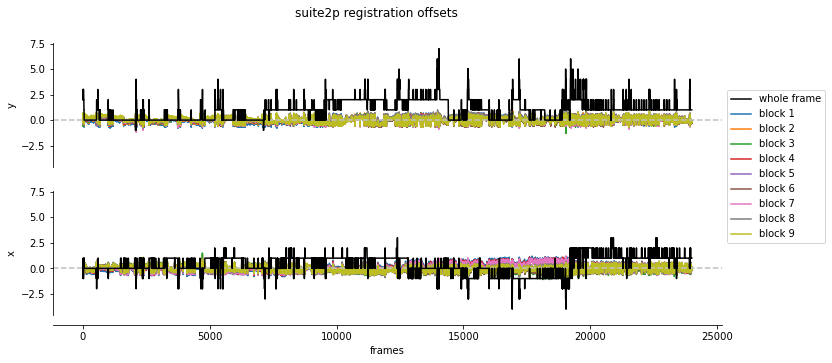

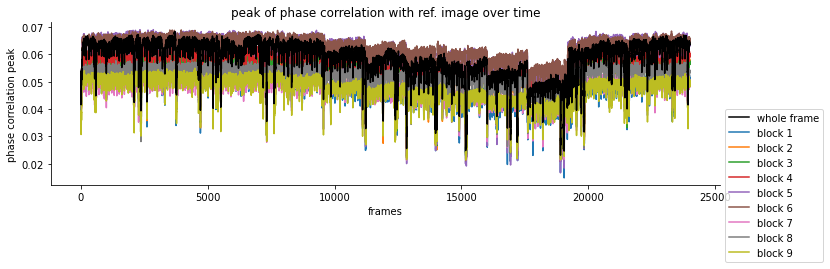

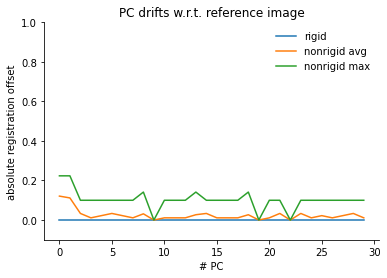

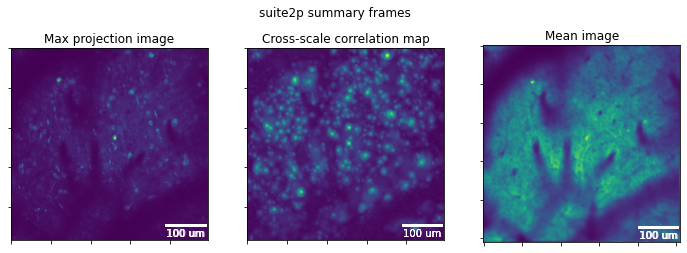

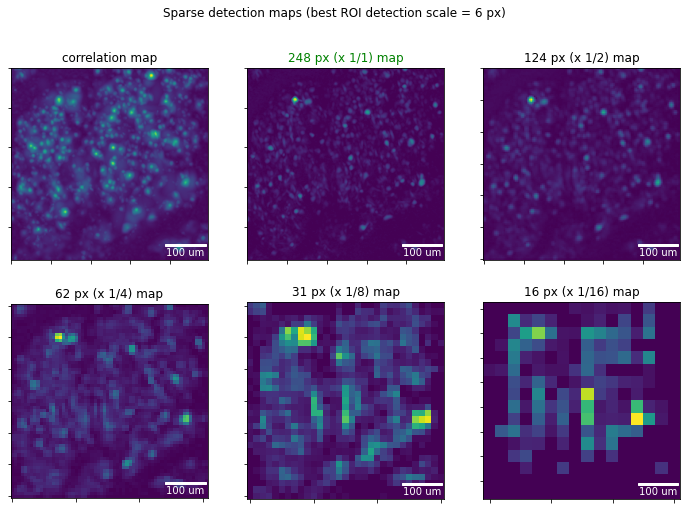

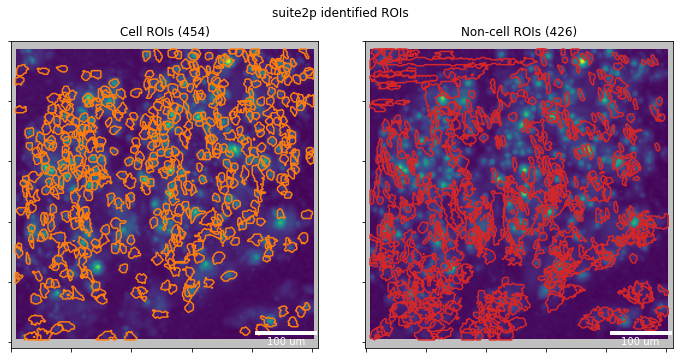

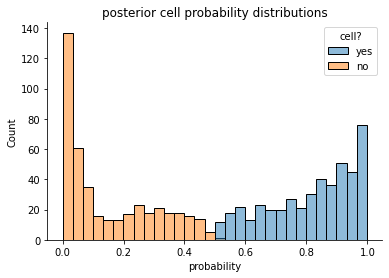

In [8]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=ntrials_per_run)
fps = get_singleton(input_info_table, Label.FPS)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

# Define suite2p custom options
ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': fps,  # sampling rate (per plane)
    'do_registration': 1,  # whether or not to perform image registration,
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': False,  # perform PCA denoising of the registered stack prior to ROI detection
}

# Run suite2p with custom options
s2p_basedir = run_s2p_and_rename(
    ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

# Load suite2p output data and extract options dictionary
s2p_output_fpath = os.path.join(s2p_input_dirs[0], s2p_basedir, 'plane0')
s2p_data = get_suite2p_data(s2p_output_fpath, withops=True, s2p_basedir=s2p_basedir)
s2p_ops = s2p_data.pop('ops')
outstack_label = get_s2p_stack_label(s2p_ops)

# Check that number of runs and number of frames per run extracted from suite2p output
# are consistent with suite2p inputs
nruns_out = len(s2p_ops['filelist'])
assert nruns == nruns_out, f'inconsistent number of runs between input and output: {nruns} and {nruns_out}'
del nruns_out
nframes_per_run_out = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run_out) == 1,  'inconsistent number of frames for each run in output'
nframes_per_run_out = nframes_per_run_out[0]
assert nframes_per_run == nframes_per_run_out, f'inconsistent number of frames per run between input and output: {nframes_per_run} and {nframes_per_run_out}'
del nframes_per_run_out

# Generate info table from suite2p output, and map suite2p processed file indexes
# with input files indexes (for comparative plotting purposes)
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=ntrials_per_run)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
del output_info_table['code']

# Log info table
logger.info('output info table corresponding to suite2p processing order:')
print(output_info_table)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:

    # View output stack
    istimframes_stacked = np.tile(i_stim_frames_run, (nruns, 1))
    for i in range(nruns):
        istimframes_stacked[i] += i * nframes_per_run
    istimframes_stacked = istimframes_stacked.flatten()
    irun_eq = output_to_input_mapping[irun_inspect]
    runbounds = [nframes_per_run * irun_eq, nframes_per_run * (irun_eq + 1) - 1]
    stackdict = s2p_ops
    stacktitle = f'{outstack_label} stack (run {irun_inspect} -> output {irun_eq})'
    registered_stack = get_s2p_stack(s2p_ops, bounds=runbounds)

    # Plot stack histogram
    figs[f'registered_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
        title=f'run {irun_inspect} - stacks comparison')
    
    # Plot stack frequency spectrum
    figs[f'registered_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
        1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    # That is a good opportunity to check that our mapping of input stacks
    # to suite2p output stacks is correct.
    fig = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        },
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')
    figs[f'registered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        s2p_ops, title=outstack_label, bounds=runbounds, ax=fig.axes[0])

# Plot registration offsets over time
figs['registered_offsets'] = plot_suite2p_registration_offsets(
    s2p_ops, title='suite2p registration offsets')

# Plot registration quality metrics (phase correlation peak & PC drifts)
figs['phasecorrpeak_over_time'] = plot_suite2p_phase_corr_peak(s2p_ops)
figs['PCdrifts'] = plot_suite2p_PC_drifts(s2p_ops)

# Plot suite2p summary images
figs['registered_images'] = plot_suite2p_registration_images(
    s2p_ops, title='suite2p summary frames', um_per_px=daq_settings['micronsPerPixel'])

# Plot sparse detection maps
figs['sparse_maps'] = plot_suite2p_sparse_maps(
    s2p_ops, um_per_px=daq_settings['micronsPerPixel'])

# Plot detected ROIs on FOV
figs['identified_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='suite2p identified ROIs',
    um_per_px=daq_settings['micronsPerPixel'], mode='contour')

# Plot posterior cell probabilities for all ROIs 
figs['ROI_prob_dists'] = plot_suite2p_ROI_probs(s2p_data['iscell'])

view_stack(stackdict, title=stacktitle, bounds=runbounds, ilabels=istimframes_stacked)

## Post-processing (raw F traces to z-score traces)

### Load processed data if available

In [9]:
postpro_outdir = os.path.join(s2p_input_dirs[0], s2p_basedir, 'processed')
is_postpro_data_available = check_data(postpro_outdir, nruns)
if is_postpro_data_available:
    logger.info('loading data...')
    Ftimeseries, output_info_table, ROI_masks = load_data(postpro_outdir, nruns)

 28/12/2021 20:25:13: processed data is available in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11122019/mouse12/region1/suite2p_fs_3.56_reg_tif_tau_1.25/processed" directory
 28/12/2021 20:25:13: loading data...
 28/12/2021 20:25:13: loading experiment info table...
 28/12/2021 20:25:13: loading z-score data for run 0...
 28/12/2021 20:25:13: loading z-score data for run 1...
 28/12/2021 20:25:13: loading z-score data for run 2...
 28/12/2021 20:25:13: loading z-score data for run 3...
 28/12/2021 20:25:13: loading z-score data for run 4...
 28/12/2021 20:25:13: loading z-score data for run 5...
 28/12/2021 20:25:14: loading z-score data for run 6...
 28/12/2021 20:25:14: loading z-score data for run 7...
 28/12/2021 20:25:14: loading z-score data for run 8...
 28/12/2021 20:25:14: loading z-score data for run 9...
 28/12/2021 20:25:14: loading z-score data for run 10...
 28/12/2021 20:25:15: loading z-score data for ru

### Get fluorescence timeseries data

In [10]:
%%skip $is_postpro_data_available

# Get fluorescence timeseries
Ftimeseries = arrays_to_dataframe({
    Label.F_ROI: s2p_data['F'],
    Label.F_NEU: s2p_data['Fneu']},
    dim_names=[Label.ROI, Label.FRAME])
logger.info(f'assembled ({describe_dataframe_index(Ftimeseries)}) fluorescence timeseries dataframe')

# Split the data into separate runs
run_delimiters = np.arange(nruns + 1) * nframes_per_run
Ftimeseries = separate_runs(Ftimeseries, nruns)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(Ftimeseries)}) form')

# Split the data into separate trials
stim_delimiters = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM
Ftimeseries = separate_trials(Ftimeseries, ntrials_per_run)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(Ftimeseries)}) form')

# Discard first trial of each run
# NOTE: on the acquisition side, nothing is wrong with the first trial of each condition.
# However, since the different runs were fed together into suite2p (in order to improve ROI identification),
# the resulting fluorescence timecourses for each ROI were computed by suite2p under the assumption of
# time continuity, which is NOT the case during run-to-run transitions. We therefore discard the first trial
# of each run, since the fluorescence data is physiologically invalid around these transitions.
from constants import ITRIALS_DISCARD
Ftimeseries = remove_trials(Ftimeseries, iremove=ITRIALS_DISCARD)
logger.info(f'filtered data ({describe_dataframe_index(Ftimeseries)})')

# Filter out non-cell ROIs
logger.info('discarding non-cell ROIs...')
iscell = s2p_data['iscell'][:, 0]
icells = np.flatnonzero(iscell)
Ftimeseries = Ftimeseries.loc[(icells)]
s2p_data = filter_s2p_data(s2p_data, icells)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

# Discard outliers based on morphological properties (if specified)
from constants import NPIX_RATIO_THR
if NPIX_RATIO_THR is not None:
    # Plot ratio of (# pixels in the whole ROI) / (# pixels in its soma) for each ROI and identify outlier ROIs
    logger.info('identifying outliers based on # pixels ratio...')
    figs['npix_ratio'], df_outliers = plot_npix_ratio_distribution(
        s2p_data['stat'], thr=NPIX_RATIO_THR)
    df_outliers[Label.ROI] = icells
    df_outliers = df_outliers.set_index(Label.ROI)
    ioutliers = np.flatnonzero(df_outliers['is_outlier'])

    # Discard outliers from data
    logger.info('updating dataset...')
    ivalids = np.flatnonzero(~df_outliers['is_outlier'])
    Ftimeseries = Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
    s2p_data = filter_s2p_data(s2p_data, ivalids)
    logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

    # Plot filtered ROIs map
    figs['filtered_ROIs'] = plot_suite2p_ROIs(
        s2p_data, s2p_ops, title='filtered suite2p ROIs',
        um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

    # Log identified outliers
    logger.info(f'identified {len(ioutliers)} outlier(s):')
    df_outliers.iloc[ioutliers]

# Extract max F_ROI value of each ROI across time
F_ROI_max = Ftimeseries[Label.F_ROI].groupby(Label.ROI).max().rename(Label.MAX_F_ROI)
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Identify invalid ROIs with zero F_ROI range 
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Plot histogram distribution of max F_ROI across ROIs
fig, ax = plt.subplots()
ax.set_title(f'max {Label.F_ROI} distribution across ROIs')
sns.despine(ax=ax)
sns.histplot(df_invalids, x=Label.MAX_F_ROI, hue='is_invalid', bins=50, ax=ax)

# Discard invalid ROIs from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_invalids['is_invalid'])
Ftimeseries = Ftimeseries.loc[(df_invalids.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

# Plot filtered ROIs map
figs['filtered_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='filtered suite2p ROIs',
    um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

# Plot fluorescence traces for all selected ROIs 
figs['F_ROI_traces_allROIs'] = plot_all_ROIs(Ftimeseries, Label.F_ROI)

# Log identified invalids
logger.info(f'identified {len(iinvalids)} invalid ROI(s):')
df_invalids.iloc[iinvalids]

# Select subset of ROIs to plot
iROIs = Ftimeseries.index.unique(level=Label.ROI)
if nROIs_inspect > 0:
    iROI_inspect = np.random.choice(iROIs, size=nROIs_inspect)
    iROI_inspect.sort()  # sort ROIs subset to ensure consistent looping
    logger.info(f'randomly selecting {len(iROI_inspect)} ROI(s) for plotting (index(es) = {iROI_inspect})')

    # # Find run with high P and DC to plot
    # irun_plt = output_info_table[
    #     (output_info_table[Label.P] == P_REF) & (output_info_table[Label.DC] == DC_REF)
    #     ].index[0]
    # logger.info(f'selecting run {irun_plt} with parameters P = {P_REF:.2f} MPa and DC = {DC_REF:.0f} % for plotting')

    # Plot longitudinal fluorescence traces for selected ROI
    figs['raw_F_traces'] = plot_traces(
        Ftimeseries[[Label.F_ROI, Label.F_NEU]], ylabel=Label.F,
        iROI=iROI_inspect, delimiters=run_delimiters)

Ftimeseries

### Compute neuropil-corrected fluorescence data

In [11]:
%%skip $is_postpro_data_available

# Compute ROI-specific neuropil coefficients minimizing specific cost function
from constants import ALPHA
nROIs = len(Ftimeseries.index.unique(Label.ROI))
costfunc = force_positive_Fc(center_around(ALPHA))
alpha_bounds = (0.2, 2)
logger.info(f'computing alphas minimizing {costfunc.__name__} function within {alpha_bounds} interval...')
with tqdm(total=nROIs - 1, position=0, leave=True) as pbar:
    alphas = Ftimeseries.groupby(Label.ROI).apply(
        pbar_update(lambda x: optimize_alpha(x, costfunc, bounds=alpha_bounds), pbar))
alphas = alphas.rename(Label.ALPHA)

# logger.info(f'computing linear regressions for F_ROI vs. F_NEU...')
# # Compute linear regressions between ROI and neuropil fluorescence profiles
# nROIs = len(Ftimeseries.index.unique(Label.ROI))
# with tqdm(total=nROIs - 1, position=0, leave=True) as pbar:
#     linreg_coeffs = Ftimeseries.groupby(Label.ROI).apply(
#         pbar_update(linreg, pbar))
# # Reorganize fitted coefficients into dataframe
# linreg_coeffs = pd.DataFrame(
#     linreg_coeffs.tolist(),
#     columns=[Label.BETA, Label.ALPHA],
#     index=linreg_coeffs.index)
# # Plot joint distribution of alpha and F0
# fg = sns.jointplot(x=Label.ALPHA, y=Label.BETA, data=linreg_coeffs)
# figs['linreg_fits'] = fg.figure

# # Plot linear regression fit for subset of selected ROIs
# figs['linregs'] = plot_linreg(Ftimeseries, iROI_inspect)

# Plot resulting distribution of neuropil subtraction coefficients
figs['alphas'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('distribution of optimal alphas across ROIs')
sns.histplot(alphas.to_frame(), x=Label.ALPHA, ax=ax, bins=30)

# Subtract neuropil background fluorescence for each ROI of interest
logger.info(f'subtracting neuropil background...')
Ftimeseries[Label.F] = Ftimeseries[Label.F_ROI] - alphas * Ftimeseries[Label.F_NEU]

if nROIs_inspect > 0:
    # Plot longitudinal fluorescence traces for selected ROI
    alphas_plt = alphas.loc[iROI_inspect].groupby(Label.ROI).first()
    figs['F_trace'] = plot_traces(
        Ftimeseries[[Label.F]],
        iROI=iROI_inspect, delimiters=run_delimiters,
        title=[f'{Label.ALPHA} = {a:.2f}' for a in alphas_plt])
    if irun_eq is not None:
        # Highlight selected run on figure
        for ax in figs['F_trace'].axes:
            ax.axvspan(run_delimiters[irun_eq], run_delimiters[irun_eq + 1], color='silver', alpha=0.5)

# Plot corrected fluorescence for all ROIs
figs['F_traces_allROIs'] = plot_all_ROIs(Ftimeseries, Label.F)

### Baseline computation & correction

The baseline of fluorescence signals is computed by applying consecutively (1) a low percentile sliding window and (2) an average sliding window, over the entire fluorescence timecourse. This is performed independently for each cell (obviously) but also for each run owing to potential discontinuities in acquisition conditions across runs (especially since the stacking order of these runs does not necessarily follow the original chronological order of acquisition).

For downstream analysis steps, we wish to consider only cells who exhibit a relatively flat activity baseline. Therefore, at this point we discard any cell whose baseline fluctuations are above a certain threshold. Since baseline fluorescence levels vary significantly across cells, we use a relative metrics (relative standard deviation RSD) to evaluate fluctuations of the baseline around its mean, and discard cells whose baseline RSD is above some defined threshold for any of the acquisition runs.

The remaining fluorescence signals are corrected by subtraction of a mean-corrected time-varying baseline.

In [12]:
%%skip $is_postpro_data_available

from constants import BASELINE_WLEN, BASELINE_QUANTILE, BASELINE_RSD_THR
Ftimeseries[Label.F0] = compute_baseline(
    Ftimeseries[Label.F], fps, BASELINE_WLEN, BASELINE_QUANTILE)

# Plot original and baseline fluorescence of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'F_F0_trace_run{irun_inspect}'] = plot_traces(
        Ftimeseries[[Label.F, Label.F0]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters,
        title=f'w = {BASELINE_WLEN:.1f} s, q = {BASELINE_QUANTILE * 1e2:.1f} %')

# Compute F0 relative standard deviation for each ROI and run
logger.info('computing baseline relative standard deviation...')
F0_RSD_per_run = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).agg(
    lambda x: np.nanstd(x) / np.abs(np.nanmean(x)))

# Identify outliers as ROIs whose max RSD across runs is above defined threshold
logger.info('identifying outliers...')
F0_RSD_max = F0_RSD_per_run.groupby(Label.ROI).max()
is_outlier = (F0_RSD_max > BASELINE_RSD_THR)
df_outliers = pd.DataFrame({'max F0 RSD': F0_RSD_max, 'is_outlier': is_outlier})
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Plot RSD distribution per ROI & run amongst remaining ROIs
ax = sns.heatmap(
    F0_RSD_per_run.drop(df_outliers.iloc[ioutliers].index).unstack(),
    vmin=0, cmap='viridis')
ax.set_title('F0 RSD distribution per ROI & run')

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
Ftimeseries = Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence dataframe')

# Mean correction of remaining signals
logger.info('subtracting mean-corrected baseline from signals...')
# Compute mean baseline value per ROI & run
F0_mean = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).mean()
# Apply baseline corretor to both fluorescence and baseline signals
baseline_corrector = Ftimeseries[Label.F0] - F0_mean
Ftimeseries[Label.F] -= baseline_corrector
Ftimeseries[Label.F0] -= baseline_corrector

# Plot baseline-corrected fluorescence signal and baseline of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'F_F0_trace_run{irun_inspect}_corrected'] = plot_traces(
        Ftimeseries[[Label.F, Label.F0]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters,
        title='after baseline correction')

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### ΔF/F0 computation

In [13]:
%%skip $is_postpro_data_available

# Compute relative change in fluorescence
logger.info('computing relative change in fluorescence...')
F0 = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).median()  # median of the baseline over each run
Ftimeseries[Label.DFF] = (Ftimeseries[Label.F] - F0) / F0

# Plot consecutive trials of relative fluorescence change of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'dFF_trace_run{irun_inspect}'] = plot_traces(
        Ftimeseries[[Label.DFF]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)

### Z-score computation

In [14]:
%%skip $is_postpro_data_available

# Fit gaussians to dFF histogram distributions
logger.info('fitting gaussians to dFF histogram distributions...')
nROIs, nruns = [len(Ftimeseries.index.unique(k)) for k in [Label.ROI, Label.RUN]]
with tqdm(total=nROIs * nruns - 1, position=0, leave=True) as pbar:
    dFF_histfits = Ftimeseries[Label.DFF].groupby([Label.ROI, Label.RUN]).agg(
        pbar_update(nan_proof(gauss_histogram_fit), pbar))
nbins = dFF_histfits.iloc[0][0].size
logger.info('extracting fitted gaussian parameters...')
dFF_histparams = dFF_histfits.apply(lambda x: x[1])
dFF_histparams = pd.DataFrame(
    dFF_histparams.tolist(),
    columns=['H', 'A', 'x0', 'sigma'],
    index=dFF_histparams.index)

# Plot histogram distributions of the relevant extracted Gaussian parameters
mkeys = ['x0', 'sigma']
figs['gaussianfits_dists'], axes = plt.subplots(1, len(mkeys), figsize=(5 * len(mkeys), 3))
figs['gaussianfits_dists'].suptitle('dFF Gaussian fit parameters distributions')
for ax, mk in zip(axes, mkeys):
    sns.despine(ax=ax)
    sns.histplot(dFF_histparams, x=mk, ax=ax)

# Plot dFF histogram distribution and fitted gaussian parameters for each ROI of interest 
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'dFF_hist_fits_run{irun_inspect}'] = plot_gaussian_histogram_fit(
        Ftimeseries, dFF_histparams, iROI_inspect, irun_eq, nbins=nbins)

# Normalize dFF traces by gaussian parameters to obtain dFF z-scores
logger.info('normalizing dFF by gaussian parameters to compute z-scores...')
Ftimeseries[Label.ZSCORE] = (Ftimeseries.loc[:, Label.DFF] - dFF_histparams['x0']) / dFF_histparams['sigma']

# Plot consecutive trials of dFF z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}'] = plot_traces(
        Ftimeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    for ax in figs[f'zscore_trace_run{irun_inspect}'].axes:
        ax.axhspan(- 1, 1, fc='silver', ec=None, alpha=0.5);

### Save z-score data

In [15]:
%%skip $is_postpro_data_available

# Reduce timeseries data to z-scores only
Ftimeseries = Ftimeseries.loc[:, [Label.ZSCORE]]
# Gather ROI masks information in dataframe
ROI_masks = get_ROI_masks(s2p_data['stat'], Ftimeseries.index.unique(level=Label.ROI))
# Save data in output directory
save_data(Ftimeseries, output_info_table, ROI_masks, postpro_outdir)

## Statistics (response metrics & cell classification)

### Create statistics dataframe

<span style="color:yellow">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

In [16]:
# Get the index dimensions of the fluorescence dataset
index_dims = {k: Ftimeseries.index.unique(k) for k in Ftimeseries.index.names}

# Create Fstats dataframes
logger.info('creating statistics dataframe')
Fstats = pd.DataFrame()
logger.info('adding validity labels...')
Fstats[Label.VALID] = Ftimeseries[Label.ZSCORE].groupby([Label.ROI, Label.RUN, Label.TRIAL]).first().notna()

# Add experimental info to Fstats
if Label.P not in Fstats:
    logger.info('adding experimental info to Fstats...')
    exp_output_table = repeat_along_new_dims(
        output_info_table.drop(Label.NTRIALS, axis=1).set_index(Label.RUN, drop=True),
        {k: index_dims[k] for k in [Label.ROI, Label.TRIAL]})
    exp_output_table = exp_output_table.reorder_levels([Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
    Fstats = pd.concat([exp_output_table, Fstats], axis=1) 

logger.info('Fstats table:')
Fstats

 28/12/2021 20:25:21: creating statistics dataframe
 28/12/2021 20:25:21: adding validity labels...
 28/12/2021 20:25:22: adding experimental info to Fstats...
 28/12/2021 20:25:22: Fstats table:


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  \
ROI run trial                                                             
1   0   0      line3           100           0.2  3.56      0.0    50.0   
        1      line3           100           0.2  3.56      0.0    50.0   
        2      line3           100           0.2  3.56      0.0    50.0   
        3      line3           100           0.2  3.56      0.0    50.0   
        4      line3           100           0.2  3.56      0.0    50.0   
...              ...           ...           ...   ...      ...     ...   
878 14  11     line3           100           0.2  3.56      0.8    80.0   
        12     line3           100           0.2  3.56      0.8    80.0   
        13     line3           100           0.2  3.56      0.8    80.0   
        14     line3           100           0.2  3.56      0.8    80.0   
        15     line3           100           0.2  3.56      0.8    80.0   

               run ID  valid  
ROI run trial                 
1   0   0         869  False  
        1         869   True  
        2         869   True  
        3         869   True  
        4         869   True  
...               ...    ...  
878 14  11        863   True  
        12        863   True  
        13        863   True  
        14        863   True  
        15        863   True  

[107760 rows x 8 columns]

### Identify trials with significant stimulus-evoked displacement

 28/12/2021 20:25:22: computing diplacement velocity over time from registration offsets...
 28/12/2021 20:25:24: identified 3 trials with significant displacement:


,,peak displacement velocity (um/s),motion
run,trial,,
2,15,7.132089,True
3,7,7.126205,True
10,12,7.695944,True


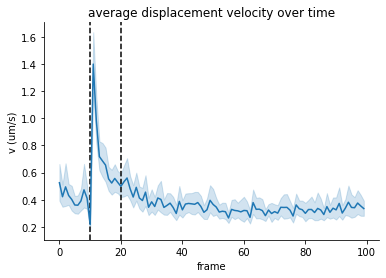

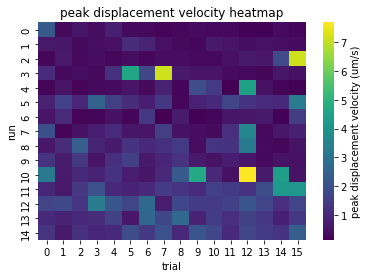

In [17]:
# Create multi-index object
mux = pd.MultiIndex.from_product(
    [np.arange(nruns), np.arange(ntrials_per_run), np.arange(NFRAMES_PER_TRIAL)],
    names=[Label.RUN, Label.TRIAL, Label.FRAME])
vdisp = compute_displacement_velocity(
    s2p_ops, mux, daq_settings['micronsPerPixel'], 1 / daq_settings['framePeriod'])
# Plot average displacement velocity profile for each run
fig, ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('average displacement velocity over time')
for idx in [FrameIndex.STIM, FrameIndex.RESPONSE.stop]:
    ax.axvline(idx, c='k', ls='--')
sns.lineplot(
    data=vdisp.to_frame(), x=Label.FRAME, y=vdisp.name, ax=ax,
    # hue=Label.RUN, ci=None, legend='full', palette='flare'
)

# Compute peak of displacement velocity within response window for each run and trial
from constants import VDISP_THR
vdisp_window = vdisp.loc[pd.IndexSlice[:, :, FrameIndex.RESPONSE]]
vdisp_peaks = vdisp_window.groupby([Label.RUN, Label.TRIAL]).agg(find_response_peak).rename(Label.PEAK_DISP_VEL)
vdisp_peaks = vdisp_peaks.to_frame()
vdisp_peaks[Label.MOTION] = vdisp_peaks[Label.PEAK_DISP_VEL] > VDISP_THR

# Add peak displacement velocity info to Fstats
exp_vdisp_peaks = repeat_along_new_dim(
    vdisp_peaks, Label.ROI, Fstats.index.unique(Label.ROI)).swaplevel(0, 2).swaplevel(1, 2).sort_index()
Fstats = pd.concat([Fstats, exp_vdisp_peaks], axis=1)

# Plot peak displacement velocity heatmap
fig, ax = plt.subplots()
ax.set_title('peak displacement velocity heatmap')
sns.heatmap(vdisp_peaks[Label.PEAK_DISP_VEL].unstack(), ax=ax, cmap='viridis')
fig.axes[1].set_ylabel(Label.PEAK_DISP_VEL)

# Log identified motion trials
logger.info(f'identified {vdisp_peaks[Label.MOTION].sum()} trials with significant displacement:')
vdisp_peaks[vdisp_peaks[Label.MOTION]]

### Set signal detection threshold based on statistical significance  

In [18]:
from constants import PTHR_DETECTION
ZTHR = pvalue_to_zscore(PTHR_DETECTION)
logger.info(f'setting significance threshold to Z = {ZTHR:.3f} (corresponding to p = {PTHR_DETECTION:.2f})')

 28/12/2021 20:25:24: setting significance threshold to Z = 2.326 (corresponding to p = 0.01)


### Identify trials with pre-stimulus activity

 28/12/2021 20:25:24: analyzing fluorescence activity in pre-stimulus intervals...
 28/12/2021 20:25:25: discarding invalid samples...
 28/12/2021 20:25:25: identified 11352 trials over 101025 (11.2 %) with significant pre-stimulus activity


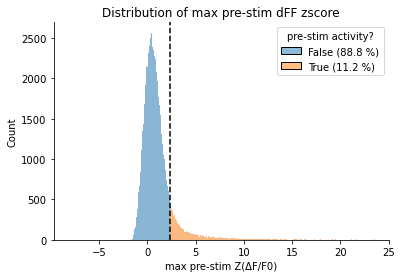

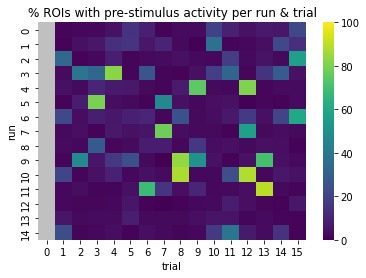

In [19]:
logger.info('analyzing fluorescence activity in pre-stimulus intervals...')
# Identify max dFF z-score in pre-stimulus window for each trial
zscore_prestim = Ftimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], Label.ZSCORE]
Fstats[Label.MAX_ZSCORE_PRESTIM] = zscore_prestim.groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).max()

# Classify pre-stimulus state based on this metrics
Fstats[Label.PRESTIM_ACTIVITY] = Fstats[Label.MAX_ZSCORE_PRESTIM] > ZTHR
nacts, ntot = Fstats[Label.PRESTIM_ACTIVITY].sum(), len(valid(Fstats))
pcts = {True: nacts / ntot * 1e2, False: (ntot - nacts) / ntot * 1e2}
logger.info(f'identified {nacts} trials over {ntot} ({nacts / ntot * 1e2:.1f} %) with significant pre-stimulus activity')

# Plot histogram distribution of pre-stimulus dFF z-score
figs['prestim_zscore_level_dist'], ax = plt.subplots()
sns.despine(ax=ax)
ax = sns.histplot(Fstats, x=Label.MAX_ZSCORE_PRESTIM, hue=Label.PRESTIM_ACTIVITY, ax=ax)
ax.axvline(ZTHR, ls='--', c='k')
ax.set_xlim(ax.get_xlim()[0], 25)
ax.set_title('Distribution of max pre-stim dFF zscore')
leg = ax.get_legend()
for t in leg.texts:
    cond = t.get_text() == 'True'
    t.set_text(f'{cond} ({pcts[cond]:.1f} %)')

# Plot number of ROIs with pre-stimulus activity for each run & trial (to see if there is a trend)
figs['pct_prestim_activity_map'] = plot_pct_ROIs_map(
    Fstats, key=Label.PRESTIM_ACTIVITY, label='pre-stimulus activity')

# Plot consecutive trials of dFF z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}_labeled'] = plot_traces(
        Ftimeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    for ir, ax in zip(iROI_inspect, figs[f'zscore_trace_run{irun_inspect}_labeled'].axes):
        # Plot estimated noise range on the z-score traces
        ax.axhspan(-1, 1, fc='silver', ec=None, alpha=0.5);
        # Plot pre-stimulus activity threshold and label trials with pre-stim activity
        ax.axhline(ZTHR, ls='--', c='k');
        mark_trials(ax, Fstats[Label.PRESTIM_ACTIVITY], ir, irun_eq)

### Compute stimlulus-evoked z-score change w.r.t. pre-stim value for each trial

 28/12/2021 20:25:31: extracting mean z-score pre-stim level for each trial...
 28/12/2021 20:25:31: computing relative z-scores changes (w.r.t. pre-stim level) for each trial...
 28/12/2021 20:25:41: applying find_response_peak function to detect events in Z(ΔF/F0) - Z(ΔF/F0)_stim signals across trials in slice(10, 20, None) index window...
 28/12/2021 20:25:46: identified 100551 events over 101025 valid trials (detection rate = 99.5 %)
 28/12/2021 20:25:49: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - all trials...
 28/12/2021 20:25:49: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - False trials...
 28/12/2021 20:25:49: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - True trials...


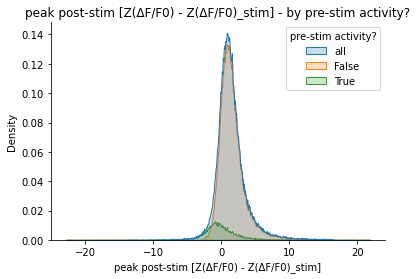

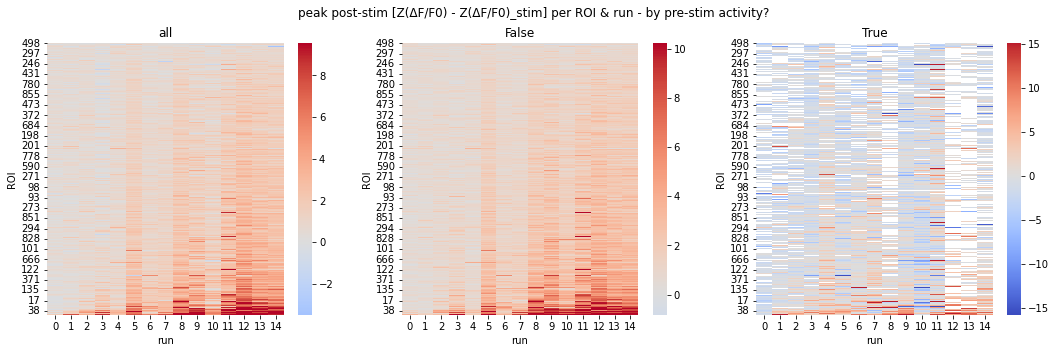

In [20]:
# Extract pre-stimulus z-score level
logger.info('extracting mean z-score pre-stim level for each trial...')
z_onset = zscore_prestim.groupby([Label.ROI, Label.RUN, Label.TRIAL]).mean()

# Subtract pre-stim z-score value to get relative z-score
logger.info('computing relative z-scores changes (w.r.t. pre-stim level) for each trial...')
Ftimeseries[Label.REL_ZSCORE] = (Ftimeseries.loc[:, Label.ZSCORE] - z_onset)

# Identify peak z-score in response window
Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM] = detect_across_trials(
    find_response_peak, Ftimeseries, FrameIndex.RESPONSE, key=Label.REL_ZSCORE)

# Plot peak z-score histogram
figs[f'peak_rel_zscore_hist'] = plot_stat_histogram(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM, groupby=Label.PRESTIM_ACTIVITY, nstd=5)

# Plot average peak z-score per ROI & run
figs[f'peak_rel_zscore_map'] = plot_stat_heatmap(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM, cmap='coolwarm',
    groupby=Label.PRESTIM_ACTIVITY, nstd=5, sort='ascend')

### Identify stimulus-evoked responses

 28/12/2021 20:25:50: identifying stimulus-evoked responses...
 28/12/2021 20:25:50: discarding invalid samples...
 28/12/2021 20:25:50: correlation coefficient between % pre-active cells and % responding cells: -0.185


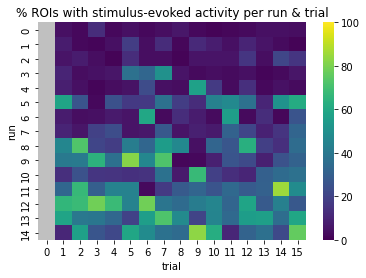

In [21]:
logger.info('identifying stimulus-evoked responses...')
# Identify "proper" responses as those with a z-score above defined threshold 
Fstats[Label.IS_RESP] = Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM] > ZTHR

# Plot number of ROIs with stimulus-evoked activity for each run & trial (to see if there is a trend)
figs['pct_resp_activity_map'] = plot_pct_ROIs_map(
    Fstats, key=Label.IS_RESP, label='stimulus-evoked activity')

# Compute correlation coefficient between % prestim-active cells and % responding cells 
ncells_stats = valid(Fstats).loc[:, [Label.PRESTIM_ACTIVITY, Label.IS_RESP]].groupby([Label.RUN, Label.TRIAL]).sum()
corr = ncells_stats[Label.IS_RESP].corr(ncells_stats[Label.PRESTIM_ACTIVITY])
logger.info(f'correlation coefficient between % pre-active cells and % responding cells: {corr:.3f}')

# Plot consecutive trials of relative z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}_labeled2'] = plot_traces(
        Ftimeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    # Label trials with pre-stim activity and those with post-stimlus response
    for (ir, ax) in zip(iROI_inspect, figs[f'zscore_trace_run{irun_inspect}_labeled2'].axes):
        # Plot estimated noise range on the z-score traces
        ax.axhspan(-1, 1, fc='silver', ec=None, alpha=0.5);
        # Plot pre-stim level and post-stim detection threshold for each trial
        z0 = z_onset.loc[ir, irun_eq]
        istart, z0 = z0.index.values, z0.values
        xstart = stim_delimiters[istart]
        for zoffset, ls in zip([0., ZTHR], [':', ':']): 
            ax.hlines(
                z0 + zoffset, xstart, xstart + NFRAMES_PER_TRIAL,
                colors='k', linestyles=ls, zorder=3)
        # Label trials with pre-stim activity and those with post-stim response
        mark_trials(ax, Fstats[Label.PRESTIM_ACTIVITY], ir, irun_eq)
        mark_trials(ax, Fstats[Label.IS_RESP], ir, irun_eq, color='C2')

### Compute baseline (spontaneous) activity rate

This step is time consuming, therefore results are saved on disk to be loaded on subsequent calls

 28/12/2021 20:25:50: loading detected peaks data...
 28/12/2021 20:25:53: discarding invalid samples...
 28/12/2021 20:25:53: baseline activity rate = 0.98
 28/12/2021 20:25:53: stimulus-evoked activity rate = 2.02
 28/12/2021 20:25:53: discarding invalid samples...
 28/12/2021 20:25:53: baseline activity rate = 8.5 %
 28/12/2021 20:25:53: stimulus-evoked activity rate = 26.2 %
 28/12/2021 20:25:53: discarding invalid samples...
 28/12/2021 20:25:53: discarding invalid samples...


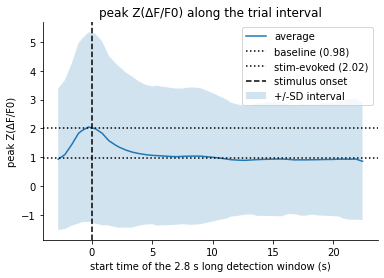

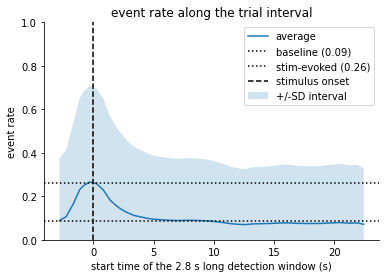

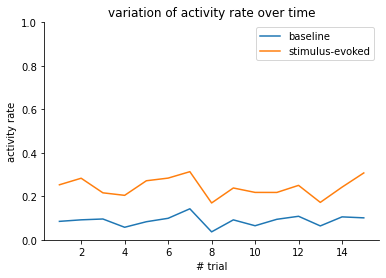

In [22]:
# Detect peaks along trial interval
from constants import NSEEDS_PER_TRIAL
wlen = FrameIndex.RESPONSE.stop - FrameIndex.RESPONSE.start
peaks_fpath = os.path.join(postpro_outdir, f'peaks_along_trial_zthr{ZTHR:.3f}_wlen{wlen}_{NSEEDS_PER_TRIAL}seeds.csv')
peaks = get_peaks_along_trial(peaks_fpath, Ftimeseries, wlen, NSEEDS_PER_TRIAL)
peaks[Label.EVENT] = peaks[Label.PEAK_ZSCORE] > ZTHR

# Plot variation in peak z-score and activity rate over trial interval
figs['peakzscore_along_trial'], baseline_zscore, evoked_zscore = plot_metrics_along_trial(
    valid(peaks)[Label.PEAK_ZSCORE], wlen, 1 / daq_settings['framePeriod'])
logger.info(f'baseline activity rate = {baseline_zscore:.2f}')
logger.info(f'stimulus-evoked activity rate = {evoked_zscore:.2f}')
figs['activity_along_trial'], baseline_activity_rate, evoked_activity_rate = plot_metrics_along_trial(
    valid(peaks)[Label.EVENT], wlen, 1 / daq_settings['framePeriod'])
logger.info(f'baseline activity rate = {baseline_activity_rate * 1e2:.1f} %')
logger.info(f'stimulus-evoked activity rate = {evoked_activity_rate * 1e2:.1f} %')

# Plot variation in baseline (spontaneous) activity rate over time
figs['activity_over_time'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('variation of activity rate over time')
ax.set_xlabel('# trial')
ax.set_ylabel('activity rate')
ax.set_ylim(0, 1)
baseline_rate_per_trial = valid(peaks)[Label.EVENT].groupby([Label.TRIAL, Label.ISTART]).mean().groupby(Label.TRIAL).median()
stimevoked_rate_per_trial = valid(Fstats)[Label.IS_RESP].groupby(Label.TRIAL).mean()
ax.plot(baseline_rate_per_trial.index, baseline_rate_per_trial.values, label='baseline')
ax.plot(stimevoked_rate_per_trial.index, stimevoked_rate_per_trial.values, label='stimulus-evoked')
ax.legend();

### Inspect response success rate

 28/12/2021 20:25:54: discarding samples with significant motion artefact...
 28/12/2021 20:25:54: discarding samples with pre-stimulus activity...
 28/12/2021 20:25:54: discarding invalid samples...
 28/12/2021 20:25:54: plotting trial-averaged success rate per ROI & run - all trials...
 28/12/2021 20:25:55: discarding samples with significant motion artefact...
 28/12/2021 20:25:55: discarding samples with pre-stimulus activity...
 28/12/2021 20:25:55: discarding invalid samples...
 28/12/2021 20:25:55: plotting trial-averaged success rate - all trials...
 28/12/2021 20:25:55: discarding samples with significant motion artefact...
 28/12/2021 20:25:55: discarding samples with pre-stimulus activity...
 28/12/2021 20:25:55: discarding invalid samples...


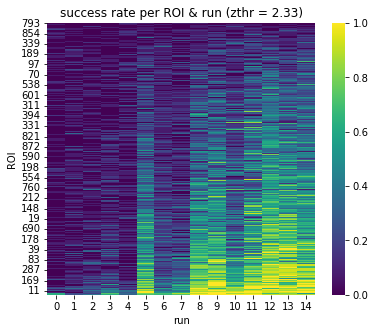

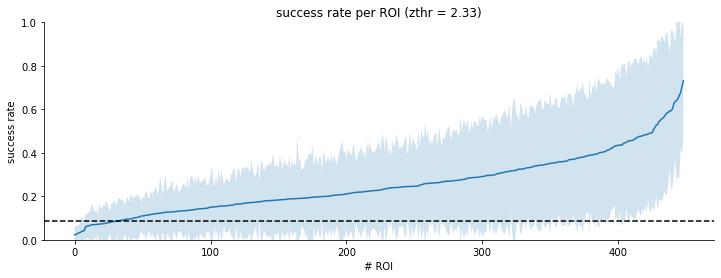

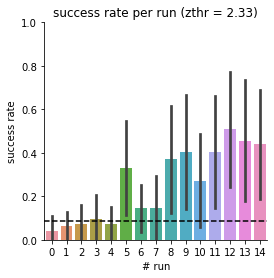

In [23]:
# Plot success rate per ROI & run
figs[f'sr_map'] = plot_stat_heatmap(
    included(Fstats), Label.IS_RESP,
    title=f'zthr = {ZTHR:.2f}', cmap='viridis', sort='ascend')
# Plot success rate per ROI
figs['sr_per_ROI'] = plot_stat_per_ROI(
    included(Fstats), Label.IS_RESP,
    title=f'zthr = {ZTHR:.2f}', sort='ascend', baseline=baseline_activity_rate)
# Plot success rate per run
figs['sr_per_run'] = plot_stat_per_run(
    included(Fstats), Label.IS_RESP,
    title=f'zthr = {ZTHR:.2f}', baseline=baseline_activity_rate)

### Compute corrected (response-only) z-scores

In [24]:
# logger.info('computing corrected z-scores (discarding no-response trials)...')
# # Extract z-scores from timeseries and stats tables
# Ftimeseries[Label.REL_ZSCORE_RESPONLY] = Ftimeseries[Label.REL_ZSCORE]
# Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY] = Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM]
# # Set no-response trials to NaN
# noresp = ~Fstats[Label.IS_RESP]
# Ftimeseries.loc[noresp, Label.REL_ZSCORE_RESPONLY] = np.nan
# Fstats.loc[noresp, Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY] = np.nan

# # Plot corrected peak z-score histogram
# figs[f'corrected_peak_rel_zscore_hist'] = plot_stat_histogram(
#     Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY, groupby=Label.PRESTIM_ACTIVITY, nstd=5)

# # Plot corrected peak z-score per ROI & run
# figs['corrected_peak_zscore_map'] = plot_stat_heatmap(
#     Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY, cmap='viridis',
#     groupby=Label.PRESTIM_ACTIVITY, nstd=2, sort='ascend')

### Classify response type per ROI

In [25]:
# logger.info('identifying "positive" runs for each ROI...')
# # Compute success rate over valid trials with no pre-stimulus activity
# is_resp_noprestim = valid(Fstats).loc[~valid(Fstats)[Label.PRESTIM_ACTIVITY], Label.IS_RESP]
# sr = get_trial_averaged(is_resp_noprestim)
# # Identify as "positive" runs those who are above a given success rate (for each ROI)
# is_positive_run = sr > SUCCESS_RATE_THR

# # Repeat along trial dimension in Fstats table
# Fstats[Label.IS_POSITIVE_RUN] = repeat_along_new_dim(
#     is_positive_run.to_frame(), 
#     Label.TRIAL, index_dims[Label.TRIAL])

# # Compute number of "positive" runs for each ROI
# logger.info('computing number of "positive" runs for each ROI...')
# n_positive_runs = is_positive_run.groupby(Label.ROI).sum().rename(Label.NPOS_RUNS)
# # Repeat along run & trial dimensions in Fstats table
# Fstats[Label.NPOS_RUNS] = repeat_along_new_dims(
#     n_positive_runs.to_frame(), 
#     {k: index_dims[k] for k in [Label.RUN, Label.TRIAL]})

# # Assign response type to each ROI based on number of positive conditions
# logger.info('classifying ROI response types...')
# resp_types = (n_positive_runs >= NPOS_CONDS_THR).astype(int).rename(Label.ROI_RESP_TYPE)
# resp_types = resp_types.map(LABEL_BY_TYPE)

# # Repeat along run & trial dimensions in Fstats table
# Fstats[Label.ROI_RESP_TYPE] = repeat_along_new_dims(
#     resp_types.to_frame(), 
#     {k: index_dims[k] for k in [Label.RUN, Label.TRIAL]})

# # Plot the histogram of the number of positive conditions per response type
# nruns = len(is_positive_run.index.unique(level=Label.RUN))
# figs[Label.NPOS_RUNS] = plot_positive_runs_hist(
#     n_positive_runs, resp_types, nruns,
#     title=f'threshold success rate = {SUCCESS_RATE_THR * 1e2} %')

### Classify ROIs according to their stimulation parameter-dependency

 28/12/2021 20:25:57: discarding samples with significant motion artefact...
 28/12/2021 20:25:57: discarding samples with pre-stimulus activity...
 28/12/2021 20:25:57: discarding invalid samples...
 28/12/2021 20:25:57: computing trial-averaged stats...
 28/12/2021 20:26:05: sub-indexing data...
 28/12/2021 20:26:05: filtering data...
 28/12/2021 20:26:05: cross-checking filters...
 28/12/2021 20:26:05: computing correlation coefficients...
 28/12/2021 20:26:05: computing trial-averaged stats...
 28/12/2021 20:26:14: sub-indexing data...
 28/12/2021 20:26:14: filtering data...
 28/12/2021 20:26:14: cross-checking filters...
 28/12/2021 20:26:14: computing correlation coefficients...
 28/12/2021 20:26:14: setting thresholds correlation coefficients for significant dependency along each dimension:
-   r(P (MPa), p = 0.050, n = 7, 1-tailed) = 0.66
-   r(DC (%), p = 0.050, n = 9, 1-tailed) = 0.58
 28/12/2021 20:26:14: expanding response types along trial dimension and adding to Fstats...

line  trial_length  duration (s)   fps  P (MPa)  DC (%)  \
ROI run trial                                                             
1   0   0      line3           100           0.2  3.56      0.0    50.0   
        1      line3           100           0.2  3.56      0.0    50.0   
        2      line3           100           0.2  3.56      0.0    50.0   
        3      line3           100           0.2  3.56      0.0    50.0   
        4      line3           100           0.2  3.56      0.0    50.0   
...              ...           ...           ...   ...      ...     ...   
878 14  11     line3           100           0.2  3.56      0.8    80.0   
        12     line3           100           0.2  3.56      0.8    80.0   
        13     line3           100           0.2  3.56      0.8    80.0   
        14     line3           100           0.2  3.56      0.8    80.0   
        15     line3           100           0.2  3.56      0.8    80.0   

               run ID  valid  peak displacement velocity (um/s)  motion  \
ROI run trial                                                             
1   0   0         869  False                           2.213400   False   
        1         869   True                           0.314346   False   
        2         869   True                           0.572107   False   
        3         869   True                           0.396720   False   
        4         869   True                           0.806246   False   
...               ...    ...                                ...     ...   
878 14  11        863   True                           0.996814   False   
        12        863   True                           1.666301   False   
        13        863   True                           1.377775   False   
        14        863   True                           1.239999   False   
        15        863   True                           2.354158   False   

               max pre-stim Z(ΔF/F0)  pre-stim activity?  \
ROI run trial                                              
1   0   0                        NaN               False   
        1                   0.548174               False   
        2                   1.235880               False   
        3                  -0.916507               False   
        4                   1.326528               False   
...                              ...                 ...   
878 14  11                  2.513644                True   
        12                  0.243725               False   
        13                  0.123641               False   
        14                  1.638892               False   
        15                  0.390295               False   

               peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]  trial response?  \
ROI run trial                                                               
1   0   0                                            NaN            False   
        1                                       0.660652            False   
        2                                       1.166315            False   
        3                                       1.790903            False   
        4                                       0.199315            False   
...                                                  ...              ...   
878 14  11                                      1.666697            False   
        12                                      3.076214             True   
        13                                      3.319524             True   
        14                                      1.233477            False   
        15                                      4.832280             True   

              response type  
ROI run trial                
1   0   0           P+, DCo  
        1           P+, DCo  
        2           P+, DCo  
        3           P+, DCo  
        4           P+, DCo  
...                     ...  
878 14  11          P+, DC+  
        12 

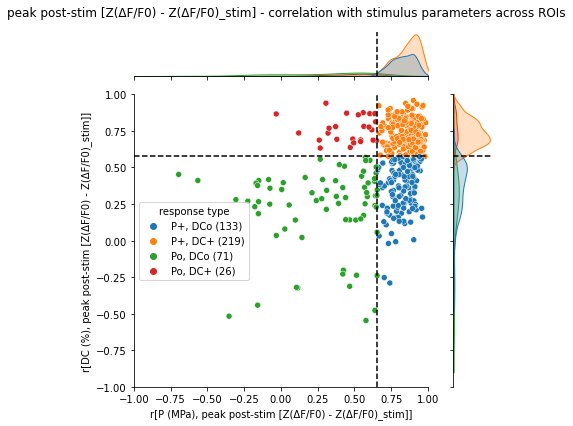

In [26]:
from constants import PTHR_DEPENDENCY
figs['new_classes'], rtypes_per_ROI = plot_params_correlations(
    included(Fstats), ykey=Label.PEAK_REL_ZSCORE_POSTSTIM, pthr=PTHR_DEPENDENCY, directional=True)
rtypes = rtypes_per_ROI.unique().tolist()

logger.info('expanding response types along trial dimension and adding to Fstats...')
if Label.ROI_RESP_TYPE in Fstats:
    del Fstats[Label.ROI_RESP_TYPE]
Fstats[Label.ROI_RESP_TYPE] = repeat_along_new_dim(
    rtypes_per_ROI.to_frame(), Label.TRIAL, Fstats.index.unique(level=Label.TRIAL))
logger.info('Fstats table:')
Fstats

## Results visualization

### Spatial distribution of cells per response type

 28/12/2021 20:26:15: plotting cells map color-coded by response type...
 28/12/2021 20:26:15: extracting responses types per ROI...


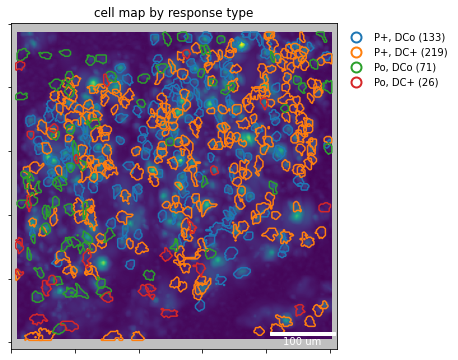

In [27]:
figs['cellmap'] = plot_cell_map(
    ROI_masks, Fstats, s2p_ops, title='cell map by response type',
    um_per_px=daq_settings['micronsPerPixel'], refkey='Vcorr', mode='contour')

### Success rate parametric dependency per response type

 28/12/2021 20:26:16: discarding samples with significant motion artefact...
 28/12/2021 20:26:16: discarding samples with pre-stimulus activity...
 28/12/2021 20:26:16: discarding invalid samples...
 28/12/2021 20:26:26: sub-indexing data...
 28/12/2021 20:26:26: filtering data...
 28/12/2021 20:26:26: cross-checking filters...
 28/12/2021 20:26:26: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. P (MPa) ...
 28/12/2021 20:26:26: discarding samples with significant motion artefact...
 28/12/2021 20:26:26: discarding samples with pre-stimulus activity...
 28/12/2021 20:26:26: discarding invalid samples...
 28/12/2021 20:26:36: sub-indexing data...
 28/12/2021 20:26:36: filtering data...
 28/12/2021 20:26:36: cross-checking filters...
 28/12/2021 20:26:36: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. DC (%) ...


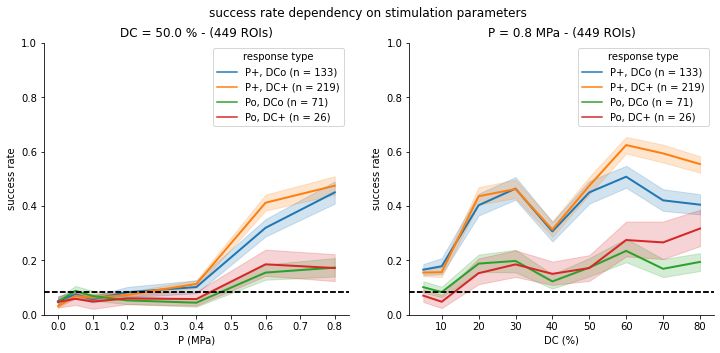

In [28]:
figs['success_rate_dependency'], axes = plt.subplots(1, 2, figsize=(12, 5))
for xkey, ax in zip([Label.P, Label.DC], axes):
    fig = plot_parameter_dependency(
        get_trial_averaged(included(Fstats)), xkey=xkey, ykey=Label.SUCCESS_RATE, ybounds=(0, 1),
        hue=Label.ROI_RESP_TYPE, hue_order=rtypes,
        ax=ax, baseline=baseline_activity_rate)
fig.suptitle('success rate dependency on stimulation parameters');

### Peak z-score parametric dependency per response type

 28/12/2021 20:26:37: discarding samples with significant motion artefact...
 28/12/2021 20:26:37: discarding samples with pre-stimulus activity...
 28/12/2021 20:26:37: discarding invalid samples...
 28/12/2021 20:26:37: selecting 0.5 - 0.75 quantile slice from peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] for each ROI type & run...
 28/12/2021 20:26:37: discarding samples with significant motion artefact...
 28/12/2021 20:26:37: discarding samples with pre-stimulus activity...
 28/12/2021 20:26:37: discarding invalid samples...
 28/12/2021 20:26:37: discarding samples with significant motion artefact...
 28/12/2021 20:26:37: discarding samples with pre-stimulus activity...
 28/12/2021 20:26:37: discarding invalid samples...
 28/12/2021 20:26:37: sub-indexing data...
 28/12/2021 20:26:37: filtering data...
 28/12/2021 20:26:37: cross-checking filters...
 28/12/2021 20:26:37: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - 

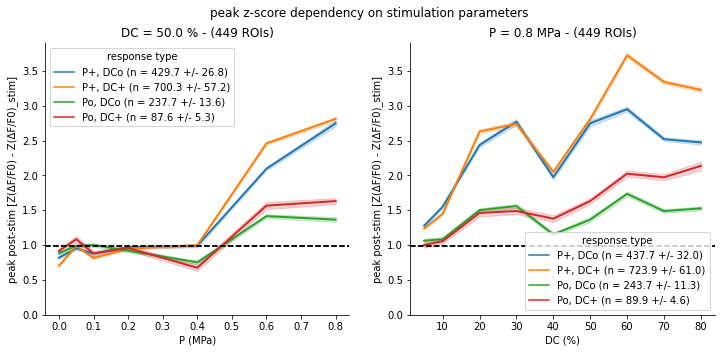

In [29]:
# If specified, select subset of responses that lie within specific quantile interval for each category & run
from constants import ZSCORE_QUANTILE_INTERVAL
subset_idx = included(Fstats).index
if ZSCORE_QUANTILE_INTERVAL is not None:
    qmin, qmax = ZSCORE_QUANTILE_INTERVAL
    ykey = Label.PEAK_REL_ZSCORE_POSTSTIM
    logger.info(f'selecting {qmin} - {qmax} quantile slice from {ykey} for each ROI type & run...')
    quantile_zcores = included(Fstats).groupby([Label.ROI_RESP_TYPE, Label.RUN])[ykey].apply(
        lambda s: get_quantile_slice(s, qmin=qmin, qmax=qmax)).reset_index(level=1, drop=True)
    quantile_zcores = quantile_zcores.to_frame().reset_index(level=Label.ROI_RESP_TYPE)
    subset_idx = quantile_zcores.index

# Plot parameter dependency of z-score for selected subset
ykey = Label.PEAK_REL_ZSCORE_POSTSTIM
figs['peak_zscore_dependency'], axes = plt.subplots(1, 2, figsize=(12, 5))
for xkey, ax in zip([Label.P, Label.DC], axes.T):
    fig = plot_parameter_dependency(
        included(Fstats).loc[subset_idx, :], xkey=xkey, ykey=ykey, ybounds=(0, None),
        hue=Label.ROI_RESP_TYPE, hue_order=rtypes, ax=ax, baseline=baseline_zscore)
harmonize_axes_limits(axes)
fig.suptitle('peak z-score dependency on stimulation parameters');

### Prepare traces data table

In [30]:
# Expand Fstats
logger.info('expanding Fstats along frame dimension...')
exp_Fstats = repeat_along_new_dim(Fstats, Label.FRAME, index_dims[Label.FRAME])
# Merge datasets
logger.info('merging datasets...')
data = pd.concat([Ftimeseries, exp_Fstats], axis=1)
# Add time to dataset
data = add_time_to_table(data)
# Select data subset for plots
plt_data = get_data_subset(included(data), subset_idx)

 28/12/2021 20:26:39: expanding Fstats along frame dimension...
 28/12/2021 20:26:49: merging datasets...
 28/12/2021 20:26:52: adding time info to table...
 28/12/2021 20:26:57: discarding samples with significant motion artefact...
 28/12/2021 20:26:59: discarding samples with pre-stimulus activity...
 28/12/2021 20:27:01: discarding invalid samples...
 28/12/2021 20:27:03: creating new multi-index (with frame level) corresponding to index subset...
 28/12/2021 20:27:03: selecting traces data from subset...


### Response type, pressure & duty cycle dependency, per category

 28/12/2021 20:27:15: sub-indexing data...
 28/12/2021 20:27:15: filtering data...
 28/12/2021 20:27:16: cross-checking filters...
 28/12/2021 20:27:16: grouping by response type, averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 28/12/2021 20:27:34: sub-indexing data...
 28/12/2021 20:27:35: filtering data...
 28/12/2021 20:27:35: cross-checking filters...
 28/12/2021 20:27:35: grouping by response type, grouping by P (MPa), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 28/12/2021 20:27:57: sub-indexing data...
 28/12/2021 20:27:58: filtering data...
 28/12/2021 20:27:58: cross-checking filters...
 28/12/2021 20:27:58: grouping by response type, grouping by DC (%), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...


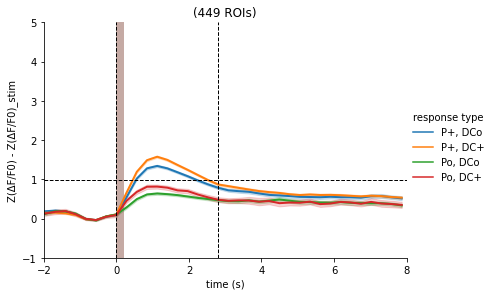

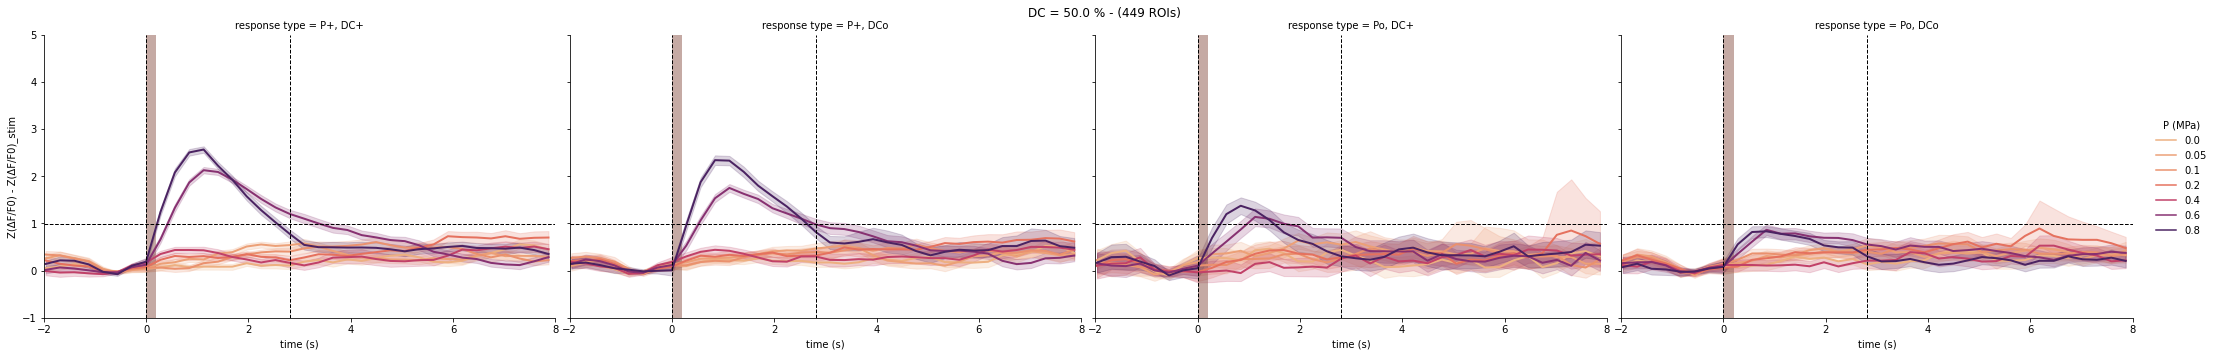

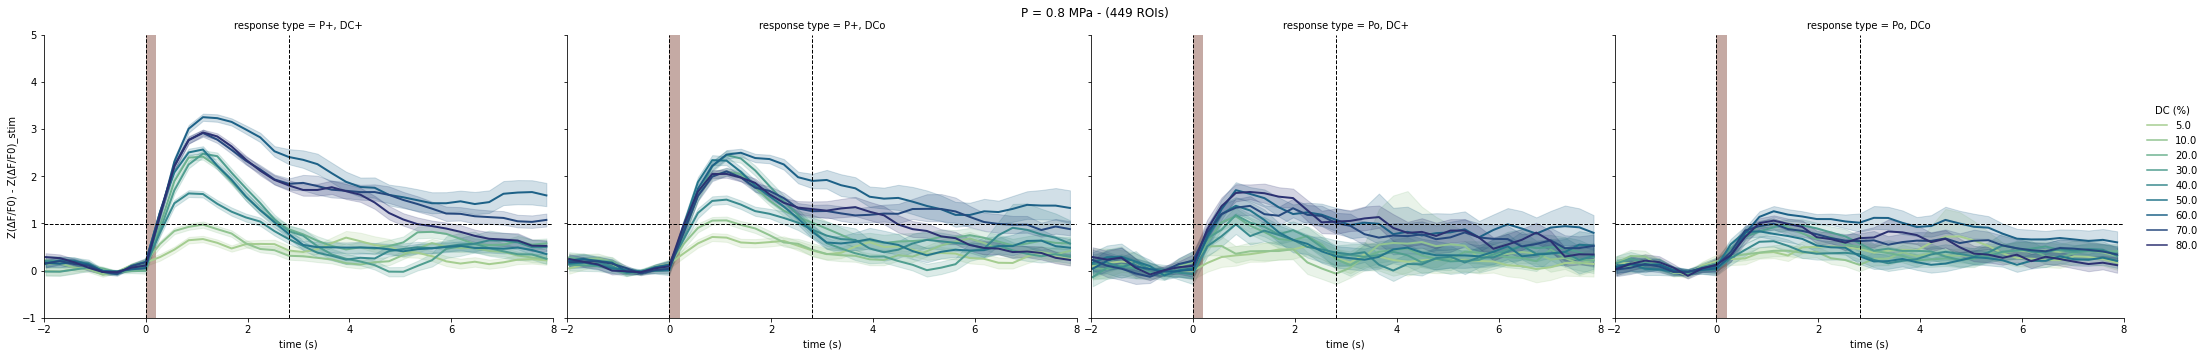

In [31]:
tbounds_response = [-2, 8.]  # s
ybounds_response = [-1, 5]   # z-score unit
ykey = Label.REL_ZSCORE
yref = baseline_zscore

# Across conditions
figs[f'responses_{ykey}_by_type'] = plot_responses(
    plt_data, ykey=ykey, yref=yref,
    hue=Label.ROI_RESP_TYPE, hue_order=rtypes,
    tbounds=tbounds_response,
    ybounds=ybounds_response)

# Pressure dependency
figs[f'responses_{ykey}_by_type_DC{DC_REF}%'] = plot_responses(
    plt_data, DC=DC_REF, ykey=ykey, yref=yref,
    hue=Label.P, col=Label.ROI_RESP_TYPE,
    tbounds=tbounds_response,
    ybounds=ybounds_response)

# Duty cycle dependency
figs[f'responses_{ykey}_by_type_P{P_REF}MPa'] = plot_responses(
    plt_data, P=P_REF, ykey=ykey, yref=yref,
    hue=Label.DC, col=Label.ROI_RESP_TYPE,
    tbounds=tbounds_response,
    ybounds=ybounds_response)

### Interactive explorer: all traces for single ROI and condition

In [32]:
# iROIs_interactive = data.index.unique(level=Label.ROI)
# view_interactive_plot(
#     lambda i: plot_responses(
#         plt_data, iROI=iROIs_interactive[i], irun=irun_plt,
#         alltraces=True, ykey=Label.ZSCORE, label=Label.SUCCESS_RATE
#         mark_peaks=True, ci=None,
#         tbounds=tbounds_response),
#     len(iROIs_interactive));

### Visualize (ROI, run) combinations with best success rate

In [33]:
# # Group by ROI and run, take first, sort by success rate, and select n bests 
# sr = included(Fstats)[Label.IS_RESP].groupby([Label.ROI, Label.RUN]).mean()
# best_sr = sr.sort_values(ascending=False).head(3)
# logger.info(f'identified combinations with best success rate:\n{best_sr}')
# ibests = best_sr.index.values
# figs['best_responders'], axes = plt.subplots(len(ibests), 1, figsize=(5, len(ibests) * 4))
# for comb, ax in zip(ibests, axes):
#     fig = plot_responses(
#         plt_data, iROI=comb[0], irun=comb[1],
#         alltraces=True, ykey=Label.REL_ZSCORE, label=Label.SUCCESS_RATE,
#         mark_peaks=True, ci=None,
#         tbounds=tbounds_response, ax=ax)
# fig.suptitle(f'(ROI x condition) combinations with {len(ibests)} best success rates')
# fig.tight_layout()

### Save figures

In [34]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs)

 28/12/2021 20:28:27: saving figure "dataset_info" on page 0
 28/12/2021 20:28:27: saving figure "registered_offsets" on page 1
 28/12/2021 20:28:27: saving figure "phasecorrpeak_over_time" on page 2
 28/12/2021 20:28:27: saving figure "PCdrifts" on page 3
 28/12/2021 20:28:28: saving figure "registered_images" on page 4
 28/12/2021 20:28:28: saving figure "sparse_maps" on page 5
 28/12/2021 20:28:28: saving figure "identified_ROIs" on page 6
 28/12/2021 20:28:28: saving figure "ROI_prob_dists" on page 7
 28/12/2021 20:28:28: saving figure "prestim_zscore_level_dist" on page 8
 28/12/2021 20:28:33: saving figure "pct_prestim_activity_map" on page 9
 28/12/2021 20:28:33: saving figure "peak_rel_zscore_hist" on page 10
 28/12/2021 20:28:33: saving figure "peak_rel_zscore_map" on page 11
 28/12/2021 20:28:35: saving figure "pct_resp_activity_map" on page 12
 28/12/2021 20:28:35: saving figure "peakzscore_along_trial" on page 13
 28/12/2021 20:28:35: saving figure "activity_along_trial" on

### Save stacks as GIFs

In [35]:
# #raw and fileted stacks from specific run
# save_stack_to_gif(
#     figsdir, {'raw': raw_stack_fpaths[irun_inspect], 'filtered': filtered_stack_fpaths[irun_inspect]},
#     ilabels=i_stim_frames_run)
# # registered stack (slice corresponding to specific run)
# save_stack_to_gif(
#     figsdir, s2p_ops, title=outstack_label,
#     ilabels=istimframes_stacked, bounds=runbounds)

### Notify upon completion

In [36]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'notebook completed in {tstamp_end - tstamp_start} s'
jupyter_slack.notify_self(s)
logger.info(s)

 28/12/2021 20:28:37: notebook completed in 0:03:34.675683 s
